In [74]:
# Basic functionalities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from collections import Counter
import pickle

In [3]:
# Web crawling
import requests
from bs4 import BeautifulSoup
import pickle

In [75]:
# Text encoding
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [80]:
# Visualization
from wordcloud import WordCloud

In [53]:
# Text Processing
from nltk import word_tokenize, pos_tag
import nltk
# nltk.set_proxy('SYSTEM PROXY')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


False

In [106]:
# Sentiment analysis
from textblob import TextBlob as tb

# Retrieve Data

## Data from google drive

In [6]:
df = pd.read_excel('DataSource.xlsx')
# remove the "who" and sort the table with "comedian"
df = df.drop('Who?', axis=1)
df = df.sort_values('Comedian')

In [26]:
# get corpus
corpus = df[['Comedian','Transcript']].set_index('Comedian')
corpus

,Transcript
Comedian,
Amy Schumer,"Well, I like to watch porn. Like, what girls i..."
Arsenio Hall,Everything’s changing. This has changed a lot....
Aziz Ansari,"I, uh, turned 30 years old this year. Yes, it’..."
CHRIS ROCK,"Oh, man, the older you get, the more shit you ..."
CHRIS ROCK,"Nah, man. But I love religion. I love watching..."
Chris Rock,"See, relationships are hard. But in order for ..."
Dave Chappelle,Don’t forget who I am. Don’t forget what I am....
Hasan Minhaj,Have you seen the show called The Slap? This i...
Hasan Minhaj,"What's up, Montreal? How are you guys? Yeah, o..."


#### Clean the data

In [27]:
def apply_data_cleansing(text):
    # Lowercase every words
    text = text.lower()
    # Remove every words with [blah blah blah] format
    text = re.sub('\[.*?\]', '', text)
    # Remove every words with (blah blah blah) format
    text = re.sub('\(.*?\)', '', text)
    # Get rid of the punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Get rid of all the numbers or words that contain numbers
    text = re.sub('\w*\d\w*', '', text)
    # Get rid of these specific punctuations
    text = re.sub('[‘’“”…]', '', text)
    # Get rid of '\n'
    text = re.sub('\n', '', text)
    return text

In [28]:
clean_corpus = pd.DataFrame(corpus.Transcript.apply(lambda x: apply_data_cleansing(x)))
clean_corpus_index = clean_corpus.reset_index()
clean_corpus_index

,Comedian,Transcript
0,Amy Schumer,well i like to watch porn like what girls in h...
1,Arsenio Hall,everythings changing this has changed a lot th...
2,Aziz Ansari,i uh turned years old this year yes its been ...
3,CHRIS ROCK,oh man the older you get the more shit you lea...
4,CHRIS ROCK,nah man but i love religion i love watching re...
5,Chris Rock,see relationships are hard but in order for an...
6,Dave Chappelle,dont forget who i am dont forget what i am i a...
7,Hasan Minhaj,have you seen the show called the slap this is...
8,Hasan Minhaj,whats up montreal how are you guys yeah oh man...
9,JACK WHITEHALL,it wasnt even the worst sign that i saw the wo...


In [29]:
# Pickles the result for later usage
clean_corpus_index.to_pickle('./pickles/clean_corpus_index.pkl')

#### Retrieve only NOUNS of all transcripts

In [30]:
def nouns(text):
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [71]:
corpus = pd.read_pickle('./pickles/clean_corpus_index.pkl')

In [69]:
# Apply the nouns function to the transcripts to filter only on nouns
corpus_nouns_index = pd.DataFrame(corpus.Transcript.apply(nouns))
corpus_nouns_index.to_pickle('./pickles/corpus_nouns_index.pkl')

#### Retrieve NOUNS and ADJECTIVES of all transcripts

In [70]:
def nouns_adj(text):
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [73]:
corpus = pd.read_pickle('./pickles/clean_corpus_index.pkl')
# Apply the nouns function to the transcripts to filter only on nouns
corpus_na_index = pd.DataFrame(corpus.Transcript.apply(nouns_adj))
corpus_na_index.to_pickle('./pickles/corpus_na_index.pkl')

# Analyize the transcripts

#### Text Encoding

In [81]:
def dtm(corpus, stop_words='english', pickle_filename="", save_pickle=False):
    cv = CountVectorizer(stop_words=stop_words)
    data_cv = cv.fit_transform(corpus.Transcript)
    data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    data_dtm.index = corpus.index
    if save_pickle:
        pickle.dump(cv, open(pickle_filename, "wb"))        
    return data_dtm.transpose()

def tf_idf(corpus, stop_words='english', pickle_filename="", save_pickle=False):
    vectorizer = TfidfVectorizer(stop_words='english')
    data_v = vectorizer.fit_transform(corpus.Transcript)
    data_tfidf = pd.DataFrame(data_v.toarray(), columns=vectorizer.get_feature_names())
    data_tfidf.index = corpus.index
    if save_pickle:
        pickle.dump(vectorizer, open(pickle_filename, "wb"))        
    return data_tfidf.transpose()

#### Top words

In [82]:
def get_top_words(matrix_dataframe, number_of_words = 30):
    top_dict = {}
    for c in matrix_dataframe.columns:
        top = matrix_dataframe[c].sort_values(ascending=False).head(number_of_words)
        top_dict[c]= list(zip(top.index, top.values))
    return top_dict

In [83]:
# Get all kinds of corpus
clean_corpus = pd.read_pickle('./pickles/clean_corpus_index.pkl')
corpus_n = pd.read_pickle('./pickles/corpus_nouns_index.pkl')
corpus_na = pd.read_pickle('./pickles/corpus_na_index.pkl')

all_corpuses = [clean_corpus, corpus_n, corpus_na]

In [84]:
df_dtms = []
df_tf_idfs = []
dtm_tops = []
tf_idf_tops = []
for corpus in all_corpuses:
    # Document-Term Matrix
    df_dtm = dtm(corpus)
    # Tf-Idf Matrix
    df_tfidf = tf_idf(corpus)    
    # Get top words
    dtm_top = get_top_words(df_dtm)
    tf_idf_top = get_top_words(df_tfidf)
    
    df_dtms.append(df_dtm)
    df_tf_idfs.append(df_tfidf)
    dtm_tops.append(dtm_top)
    tf_idf_tops.append(tf_idf_top)

In [85]:
# Have a glimps on the top words of each transcript

df = pd.DataFrame(index=df_dtms[0].columns)
for i, corpus in enumerate(all_corpuses):
    dtm_top = dtm_tops[i]
    tf_idf_top = tf_idf_tops[i]
    df[f'corpus{i}_DTM'] = [[w[0] for w in words] for words in dtm_top.values()]
    df[f'corpus{i}_TF_IDF'] = [[w[0] for w in words] for words in tf_idf_top.values()]
    
df

,corpus0_DTM,corpus0_TF_IDF,corpus1_DTM,corpus1_TF_IDF,corpus2_DTM,corpus2_TF_IDF
0,"[like, im, just, dont, know, oh, thats, porn, ...","[like, porn, im, just, girls, dating, funny, w...","[im, guy, time, girl, thats, girls, end, porn,...","[girls, porn, girl, im, guy, end, director, ti...","[im, time, guy, porn, thats, girl, right, girl...","[porn, girls, im, girl, guy, end, director, ti..."
1,"[phone, got, youre, shit, thats, oh, like, new...","[phone, motherfucker, palpitations, case, woke...","[phone, youre, motherfucker, thats, case, shes...","[phone, motherfucker, palpitations, case, hear...","[phone, new, youre, thats, motherfucker, shit,...","[phone, motherfucker, palpitations, important,..."
2,"[baby, like, im, ha, year, youre, got, theyre,...","[baby, ha, wallet, chain, year, babies, like, ...","[baby, year, ha, wallet, youre, chain, time, f...","[baby, ha, chain, wallet, year, babies, option...","[baby, ha, year, chain, youre, wallet, kids, i...","[baby, ha, wallet, chain, year, babies, ready,..."
3,"[right, house, thats, dont, theyll, fellas, go...","[house, theyll, housewife, fellas, right, dadd...","[house, thats, man, ok, woman, housewife, fell...","[house, housewife, ok, fellas, picture, husban...","[house, thats, good, man, theyll, fellas, ok, ...","[house, theyll, housewife, fellas, ok, picture..."
4,"[god, like, religion, mistakes, make, thats, s...","[mistakes, religion, shabba, god, make, happen...","[mistakes, religion, god, youre, shabba, fuck,...","[mistakes, religion, shabba, god, quicksand, t...","[god, mistakes, religion, shabba, youre, fuck,...","[mistakes, religion, shabba, god, bible, carib..."
5,"[fuck, make, shit, yes, woman, fellas, fucking...","[fellas, yes, fuck, focus, cos, motherfucker, ...","[shit, woman, motherfucker, fuck, focus, fella...","[focus, motherfucker, woman, fellas, sense, co...","[shit, woman, motherfucker, fellas, fuck, shes...","[fellas, cos, focus, motherfucker, woman, shit..."
6,"[got, years, dont, mike, forget, know, pence, ...","[mike, pence, forget, spirit, anthem, involved...","[years, pence, people, simpson, king, forget, ...","[pence, simpson, forget, anthem, king, spirit,...","[years, black, people, pence, mike, dont, time...","[mike, pence, anthem, king, simpson, dr, spiri..."
7,"[birthday, like, kid, im, hes, left, just, say...","[birthday, kid, slapped, spelling, left, dad, ...","[birthday, kid, hes, look, people, im, dad, sl...","[birthday, kid, dad, hes, look, toys, party, b...","[birthday, im, kid, look, hes, people, dad, be...","[birthday, kid, dad, look, hes, toys, camry, h..."
8,"[like, im, guys, dont, oh, just, hersheys, rig...","[like, hersheys, guys, town, married, im, smal...","[im, town, thats, hes, hersheys, right, chocol...","[town, hersheys, im, immigrants, chocolate, we...","[im, town, hersheys, small, hes, oh, thats, im...","[hersheys, town, small, immigrants, im, chocol..."
9,"[swimming, pool, diarrhea, sign, hotel, active...","[swimming, diarrhea, sign, pool, hotel, active...","[sign, pool, hotel, diarrhea, kind, day, im, y...","[sign, pool, hotel, diarrhea, kind, case, yes,...","[pool, sign, diarrhea, hotel, active, kind, ye...","[diarrhea, sign, pool, hotel, active, kind, ca..."


Since there are too many words that are common among all the transcript, we need to add them to the stop-word list and redo the text encoding again.

#### Extract all common words among the transcript

In [88]:
commons = []
for c in df.columns:
    words = []
    for r in df[c]:
        top = [word for word in r]
        for t in top:
            words.append(t)    
    commons.append(Counter(words).most_common())

In [95]:
common_words_list = []
for common in commons:
    new = [word for word, count in common if count > 6]
    common_words_list.append(np.array(new))
common_words_list

[array(['like', 'dont', 'just', 'im', 'know', 'thats', 'right', 'shit',
        'youre', 'got', 'time', 'people', 'oh', 'come', 'gonna', 'think',
        'man', 'fucking', 'guys', 'want', 'fuck', 'let', 'say', 'guy',
        'hes', 'yeah', 'said', 'love', 'okay', 'look', 'theres'],
       dtype='<U7'),
 array(['like', 'im', 'dont', 'know', 'just', 'thats', 'right', 'got',
        'gonna', 'shit', 'fucking'], dtype='<U7'),
 array(['im', 'thats', 'time', 'people', 'youre', 'man', 'shit', 'dont',
        'thing', 'gon', 'guy', 'way', 'life', 'hes', 'right', 'things',
        'fuck', 'car', 'woman', 'kids', 'theyre', 'house', 'lot'],
       dtype='<U6'),
 array(['im', 'thats', 'youre', 'time', 'man', 'hes', 'shit', 'people',
        'guy'], dtype='<U6'),
 array(['im', 'time', 'shit', 'thats', 'people', 'youre', 'man', 'good',
        'right', 'dont', 'guy', 'thing', 'gon', 'way', 'hes', 'oh', 'god',
        'hey', 'new', 'woman', 'fuck', 'white', 'house', 'okay'],
       dtype='<U6'),
 arr

In [96]:
pickle.dump(common_words_list, open('./pickles/common_words_list_index.pkl', 'wb'))

#### Add the stop words to the original stop word list and redo the text encoding

In [97]:
stop_words_list = []
for common_words in common_words_list:
    stop_words = text.ENGLISH_STOP_WORDS.union(common_words)
    stop_words_list.append(stop_words)

In [98]:
for i, stop_words in enumerate(stop_words_list):
    if i % 2 == 0:
        # Document-Term Matrix
        df_dtm = dtm(corpus, stop_words, f'./pickles/index_corpus{int(i/2)}_cv.pkl', save_pickle=True)
        # Transpose back to comedians as index for topic modeling
        df_dtm.to_pickle(f'./pickles/index_corpus{int(i/2)}_dtm.pkl')
    else:
        # Tf-Idf Matrix
        df_tfidf = tf_idf(corpus, stop_words, f'./pickles/corpus{int((i-1)/2)}_tf_idf.pkl', save_pickle=True)  
        # Transpose back to comedians as index for topic modeling  
        df_tfidf.to_pickle(f'./pickles/index_corpus{int((i-1)/2)}_tim.pkl')

### Visualize the top words with WordCloud

In [100]:
# 
wc_list = []
for stop_words in stop_words_list:
    wc = WordCloud(stopwords=stop_words,
                   background_color="white", 
                   colormap="Dark2",
                   max_font_size=150, 
                   random_state=42)
    wc_list.append(wc)

------------- Stop words 0 -------------


ValueError: num must be 1 <= num <= 24, not 25

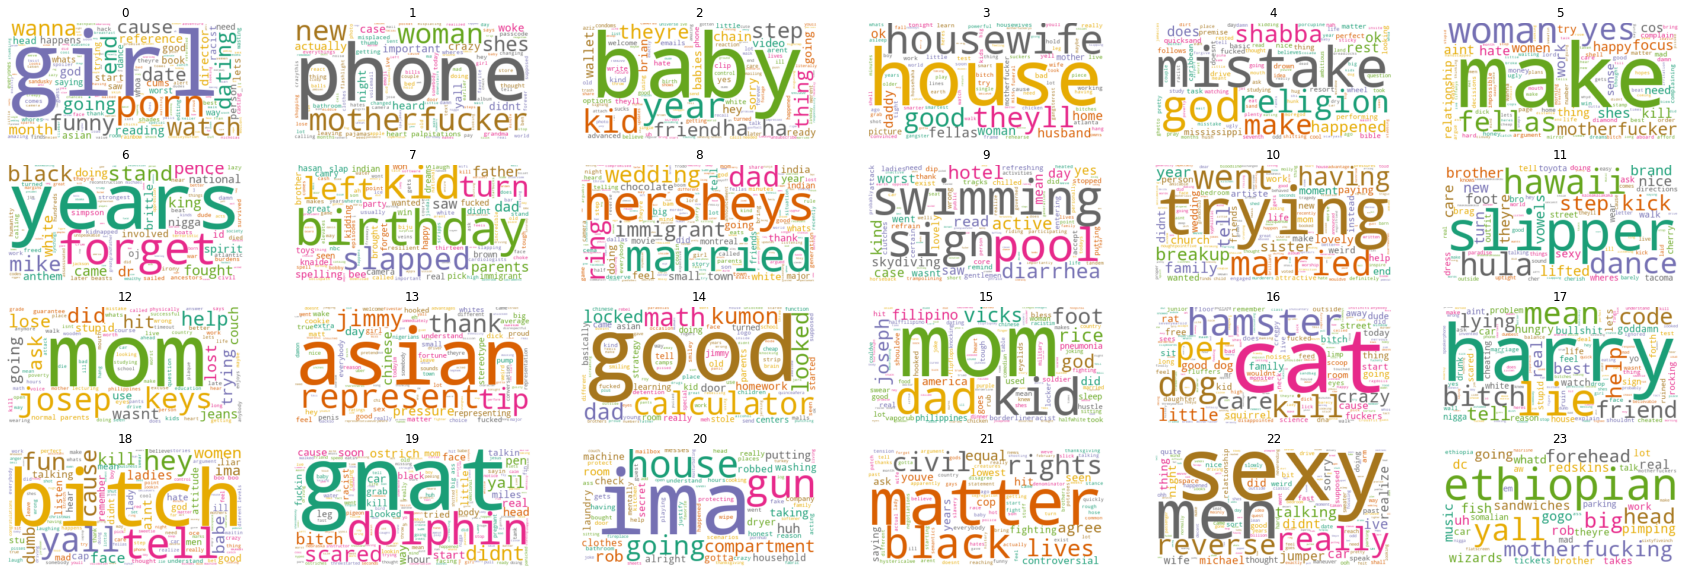

In [103]:
### the index should be 1 < num < 25
# plt.rcParams['figure.figsize'] = [30,10]

# index_now = clean_corpus.index

# for i, wc in enumerate(wc_list):
#     fig = plt.figure()
#     if i == 0 or i == 1:
#         corpus = clean_corpus
#     elif i == 2 or i == 3:
#         corpus = corpus_n
#     elif i == 4 or i == 5:
#         corpus = corpus_na
#     print(f"------------- Stop words {i} -------------")
#     # Create subplots for each transcript
#     for index, comedian in enumerate(index_now):
#         wc.generate(corpus.Transcript[index])
#         plt.subplot(4, 6, index+1)
#         plt.imshow(wc, interpolation="bilinear")
#         plt.axis("off")
#         plt.title(index_now[index])

#     plt.show()

# Sentiment Analysis

In [108]:
corpus_filename = './pickles/corpus_na_index.pkl'
clean_corpus = pd.read_pickle(corpus_filename)

In [109]:
pol = lambda x: tb(x).sentiment.polarity
sub = lambda x: tb(x).sentiment.subjectivity

data = pd.DataFrame()
data['polarity'] = clean_corpus['Transcript'].apply(pol)
data['subjectivity'] = clean_corpus['Transcript'].apply(sub)
data

,polarity,subjectivity
0,0.038222,0.554380
1,0.001132,0.589421
2,0.124939,0.521631
3,0.051190,0.575707
4,0.039598,0.618367
5,-0.042416,0.631802
6,0.025641,0.483333
7,0.219862,0.491335
8,-0.044591,0.478416
9,0.034048,0.595655


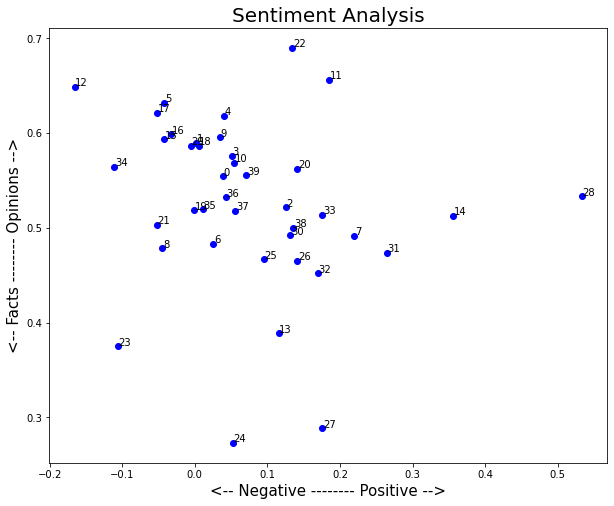

In [110]:
plt.rcParams['figure.figsize'] = [10, 8]

for index, comedian in enumerate(data.index):
    x = data.polarity.loc[comedian]
    y = data.subjectivity.loc[comedian]
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, data.index[index], fontsize=10)
#     plt.xlim(-.01, .12) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()